# Combing Models

Now we might want to combine different models together. For example, we might want to fit a transit simultaneously with its systematics (polynomials in time, x, y, background etc.). This is very similar to the Transit and Polynomial tutorials, so if you haven't looked at those tutorials I recommend you do before this one!

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.0.2!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.3.10
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


Generate some simulated data. This time we will use the handy `.inject_systematics()` and `.inject_noise()` functions in `chromatic`

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

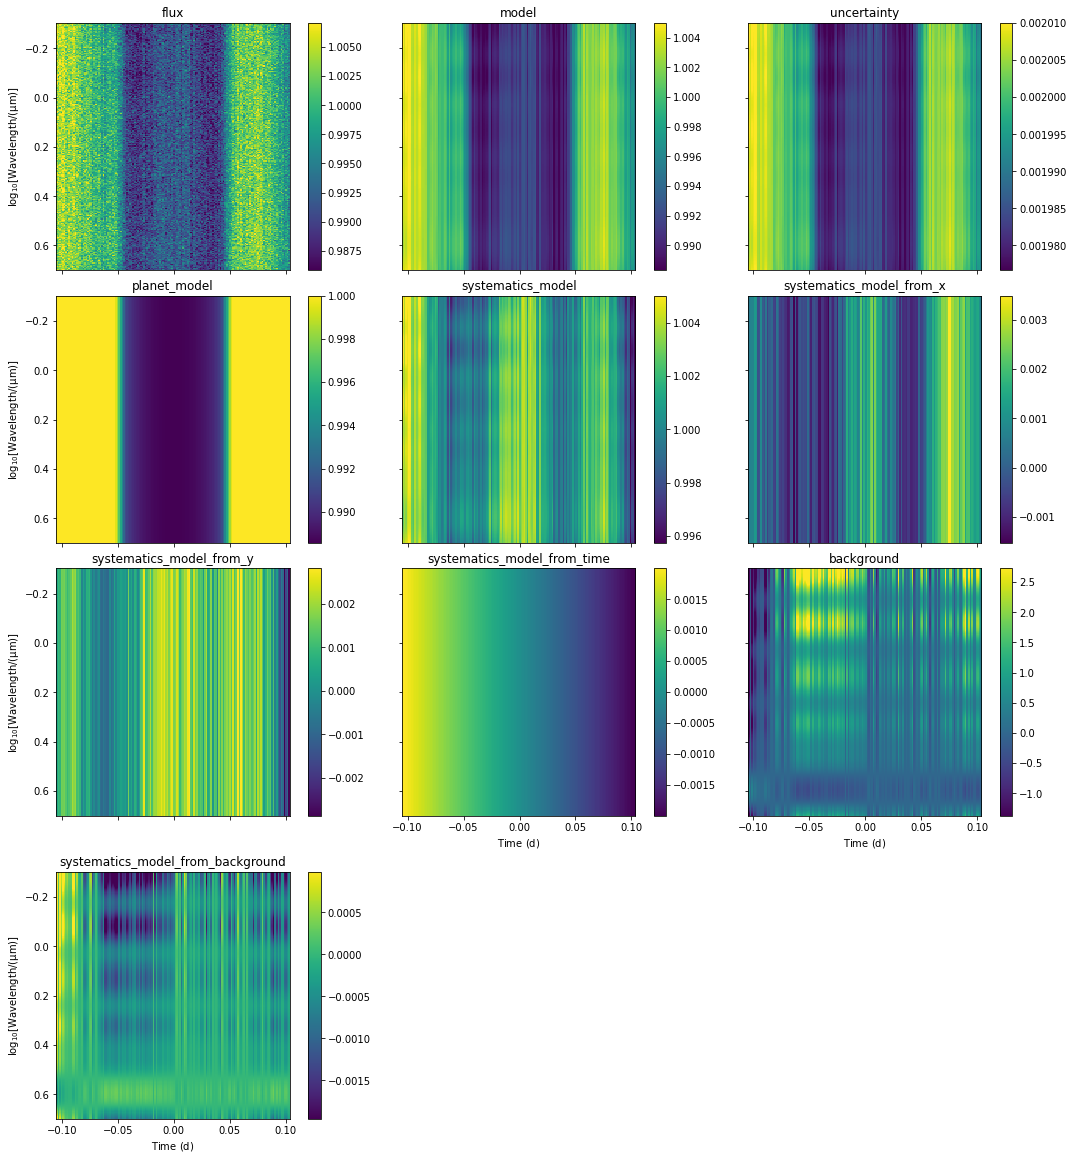

In [2]:
# create a basic simulated data set
s = SimulatedRainbow()
# inject a transit and noise as well as systematics in x, y, background and time.
s = s.inject_transit().inject_systematics(amplitude=0.002).inject_noise(signal_to_noise=500)

# show all the Rainbow.fluxlike quantities:
s.imshow_quantities();
# finally, we will bin our lightcurves to make this tutorial run faster!
s = s.bin(nwavelengths=int(s.nwave/5), dt=5 * u.minute)

Set up the transit and polynomial models. This is where we can set the distributions for every parameter, the names of the models, the degree of the polynomials, the variables we want to relate the polynomials to, etc. Here we decided to just model linear polynomials (with degree=1) for each systematic variable: 

In [3]:
# set up transit model:
t = TransitModel()
t.initialize_empty_model()
t.setup_parameters(
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=Fitted(QuadLimbDark,testval=[0.05,0.35]),
                    baseline = 1.0
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.initialize_empty_model()
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.initialize_empty_model()
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.initialize_empty_model()
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

We can combine the models by using the standard arithmetic operators: +, -, * and /. In this case I will multiply the transit model by the sum of all the systematic polynomials. *Note: we have to be careful here not to have multiple different variables that all describe some constant offset.* For example, in the transit model we have the 'baseline' parameter that determines the out-of-transit constant flux. But in the polynomials we can also fit for the 0th order flux, 'p_0'. We should be careful not to fit for both! (By default 'p_0' will be set to 0.0 in the models where we don't define it.)

In [4]:
cm = t * (b + b_x + b_y + b_bkg)
cm

<chromatic combined model 'combined' 🌈, models: <chromatic polynomial model 'stime' 🌈> + <chromatic polynomial model 'sx' 🌈> + <chromatic polynomial model 'sy' 🌈> + <chromatic polynomial model 'sbkg' 🌈> * <chromatic transit model 'transit' 🌈>

The individual models will be stored in a dictionary under `.chromatic_models`:

In [5]:
cm.chromatic_models

{'stime': <chromatic polynomial model 'stime' 🌈>,
 'sx': <chromatic polynomial model 'sx' 🌈>,
 'sy': <chromatic polynomial model 'sy' 🌈>,
 'sbkg': <chromatic polynomial model 'sbkg' 🌈>,
 'transit': <chromatic transit model 'transit' 🌈>}

Let's see what parameters we have in our models:

In [6]:
cm.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_ratio =
  <🧮 WavelikeFitted Normal(mu=0.1, sigma=0.05, name='transit_radius_ratio') for each wavelength 🧮>

transit_period =
  <🧮 Fixed | 1 🧮>

transit_epoch =
  <🧮 Fitted Uniform(lower=-0.05, upper=0.05, name='transit_epoch') 🧮>

transit_baseline =
  <🧮 Fixed | 

Then we just attach the Rainbow data to the model and run `.setup_lightcurves()` and `.setup_likelihood()` as in the previous tutorials:

In [7]:
cm.attach_data(s)
cm.setup_lightcurves(store_models=True) # store_models can be used later to speed up debugging/plotting
cm.setup_likelihood()

  0%|          | 0/5 [00:00<?, ?it/s]

If we look at our `PyMC3` model we can see that it has a lot of parameters (the combination of all our models) to optimize!

In [8]:
print(cm.pymc3_model)

                            stime_p_1 ~ Normal
                               sx_p_1 ~ Normal
                               sy_p_1 ~ Normal
                             sbkg_p_1 ~ Normal
             transit_epoch_interval__ ~ TransformedDistribution
    transit_impact_parameter_impact__ ~ TransformedDistribution
    transit_stellar_radius_interval__ ~ TransformedDistribution
      transit_stellar_mass_interval__ ~ TransformedDistribution
transit_limb_darkening_quadlimbdark__ ~ TransformedDistribution
              transit_radius_ratio_w0 ~ Normal
              transit_radius_ratio_w1 ~ Normal
              transit_radius_ratio_w2 ~ Normal
              transit_radius_ratio_w3 ~ Normal
              transit_radius_ratio_w4 ~ Normal
                       stime_model_w0 ~ Deterministic
                       stime_model_w1 ~ Deterministic
                       stime_model_w2 ~ Deterministic
                       stime_model_w3 ~ Deterministic
                       stime_model_w4 ~ D

We've got our polynomial parameters (`stime_p_1, sx_p_1, sy_p_1, sbkg_p_1`), our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio_w{N}` only. The `wavelength_{N}_data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've decided to `store_models` then we will also see a bunch of models!

But what do the actual light curves look like?

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.summarize() before calling this step!


  0%|          | 0/5 [00:00<?, ?it/s]

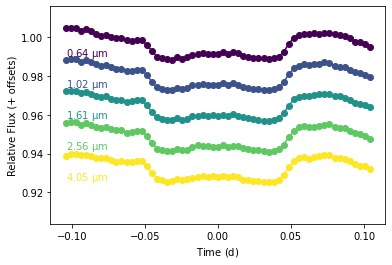

In [9]:
cm.plot_lightcurves()

We can still see the transit for each wavelength, but it's clear that the systematics would affect any derivation of the transit parameters if we didn't model for these systematics! 

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

In [10]:
# optimize for initial values!
opt = cm.optimize(plot=False)
# put those initial values into the sampling and define the number of tuning and draw steps, as well as the chains
cm.sample(start=opt, tune=4000, draws=4000, cores=4, chains=4, return_inferencedata=False)

optimizing logp for variables: [transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -60671.50973225606 -> -9142.03249055049
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_radius_ratio_w4, transit_radius_ratio_w3, transit_radius_ratio_w2, transit_radius_ratio_w1, transit_radius_ratio_w0, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]



🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppfSampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 305 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 692 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7786461956964812, but should be close to 0.9. Try to increase the number of tuning steps.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.

🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value encountered in double_scalars
🌈 Warning: invalid value enco

                             mean        sd    hdi_3%   hdi_97%     mcse_mean  \
stime_p_1               -0.001607  0.000021 -0.001644 -0.001566  9.000000e-07   
sx_p_1                  -0.001854  0.000023 -0.001898 -0.001811  1.200000e-06   
sy_p_1                  -0.000570  0.000015 -0.000598 -0.000544  4.000000e-07   
sbkg_p_1                -0.000489  0.000014 -0.000516 -0.000464  7.000000e-07   
transit_radius_ratio_w0  0.093026  0.000245  0.092558  0.093477  7.000000e-06   
...                           ...       ...       ...       ...           ...   
combined_model_w4[56]    0.998982  0.000021  0.998942  0.999023  2.000000e-07   
combined_model_w4[57]    0.998030  0.000030  0.997972  0.998086  6.000000e-07   
combined_model_w4[58]    0.997521  0.000038  0.997448  0.997591  1.400000e-06   
combined_model_w4[59]    0.996685  0.000038  0.996610  0.996753  1.200000e-06   
combined_model_w4[60]    0.995528  0.000060  0.995421  0.995641  3.100000e-06   

                           

In [19]:
# print out a nice summary table of our results!
cm.summarize(round_to=7, fmt='wide')

Summarize has already been run
                             mean        sd    hdi_3%   hdi_97%     mcse_mean  \
stime_p_1               -0.001607  0.000021 -0.001644 -0.001566  9.000000e-07   
sx_p_1                  -0.001854  0.000023 -0.001898 -0.001811  1.200000e-06   
sy_p_1                  -0.000570  0.000015 -0.000598 -0.000544  4.000000e-07   
sbkg_p_1                -0.000489  0.000014 -0.000516 -0.000464  7.000000e-07   
transit_radius_ratio_w0  0.093026  0.000245  0.092558  0.093477  7.000000e-06   
...                           ...       ...       ...       ...           ...   
combined_model_w4[56]    0.998982  0.000021  0.998942  0.999023  2.000000e-07   
combined_model_w4[57]    0.998030  0.000030  0.997972  0.998086  6.000000e-07   
combined_model_w4[58]    0.997521  0.000038  0.997448  0.997591  1.400000e-06   
combined_model_w4[59]    0.996685  0.000038  0.996610  0.996753  1.200000e-06   
combined_model_w4[60]    0.995528  0.000060  0.995421  0.995641  3.100000e-06 

At this stage the sampler may print out some warnings that we don't have enough tuning steps! An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the PyMC3 docs for much more detail!

Then we can plot the posterior distributions and check that they look sensible:


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

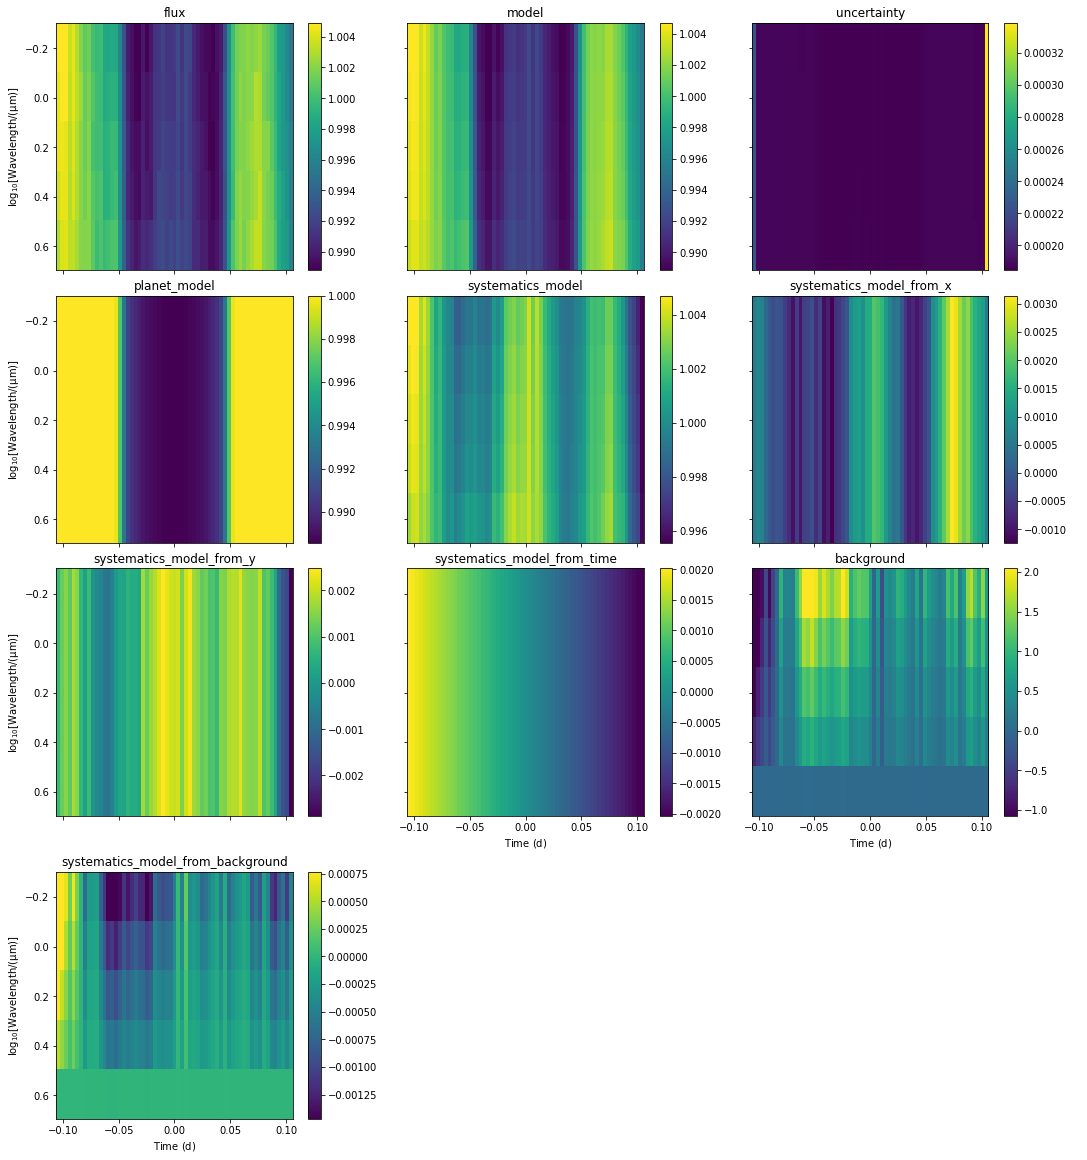

In [37]:
cm.plot_posteriors()

But what are the results?? We can easily plot the results using the handy `.get_results()` function:

In [33]:
cm.get_results()

,stime_p_0,stime_p_0_hdi_3%,stime_p_0_hdi_97%,stime_p_1,stime_p_1_hdi_3%,stime_p_1_hdi_97%,wavelength,sx_p_0,sx_p_0_hdi_3%,sx_p_0_hdi_97%,...,transit_period_hdi_97%,transit_radius_ratio,transit_radius_ratio_hdi_3%,transit_radius_ratio_hdi_97%,transit_stellar_mass,transit_stellar_mass_hdi_3%,transit_stellar_mass_hdi_97%,transit_stellar_radius,transit_stellar_radius_hdi_3%,transit_stellar_radius_hdi_97%
w0,1.0,1.0,1.0,-0.001607,-0.001644,-0.001566,0.6427920004250605 micron,0.0,0.0,0.0,...,1,0.093026,0.092558,0.093477,0.886329,0.822174,0.96018,1.168837,1.140406,1.199995
w1,1.0,1.0,1.0,-0.001607,-0.001644,-0.001566,1.0182498867257213 micron,0.0,0.0,0.0,...,1,0.092479,0.092009,0.092918,0.886329,0.822174,0.96018,1.168837,1.140406,1.199995
w2,1.0,1.0,1.0,-0.001607,-0.001644,-0.001566,1.6129831557857937 micron,0.0,0.0,0.0,...,1,0.09173,0.091258,0.092176,0.886329,0.822174,0.96018,1.168837,1.140406,1.199995
w3,1.0,1.0,1.0,-0.001607,-0.001644,-0.001566,2.5550846553145785 micron,0.0,0.0,0.0,...,1,0.091166,0.090709,0.091605,0.886329,0.822174,0.96018,1.168837,1.140406,1.199995
w4,1.0,1.0,1.0,-0.001607,-0.001644,-0.001566,4.0474431319424164 micron,0.0,0.0,0.0,...,1,0.089398,0.088952,0.089852,0.886329,0.822174,0.96018,1.168837,1.140406,1.199995


We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function:

In [36]:
models = cm.get_model()
models.keys()
# models

dict_keys(['stime', 'sx', 'sy', 'sbkg', 'transit', 'total'])

### Plotting the final results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

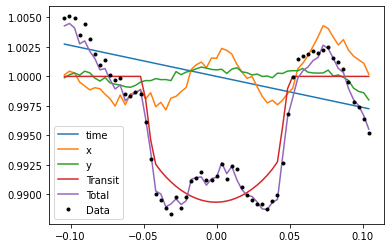

In [31]:
plt.plot(cm.data.time, models['stime']['w0'], label='time')
plt.plot(cm.data.time, 1 + np.array(models['sx']['w0']), label='x')
plt.plot(cm.data.time, 1 + np.array(models['sy']['w0']), label='y')
plt.plot(cm.data.time, models['transit']['w0'], label='Transit')
plt.plot(cm.data.time, models['total']['w0'], label='Total')
plt.plot(cm.data.time, cm.data.flux[0,:], 'k.', label = 'Data')
plt.legend();

  0%|          | 0/5 [00:00<?, ?it/s]

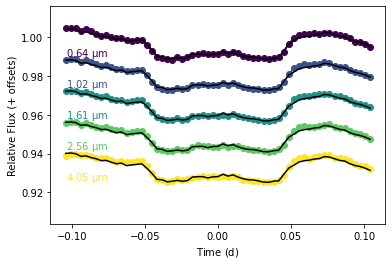

In [12]:
# plot the 2D light curves for each wavelength with the model (black) overlaid
cm.plot_lightcurves()

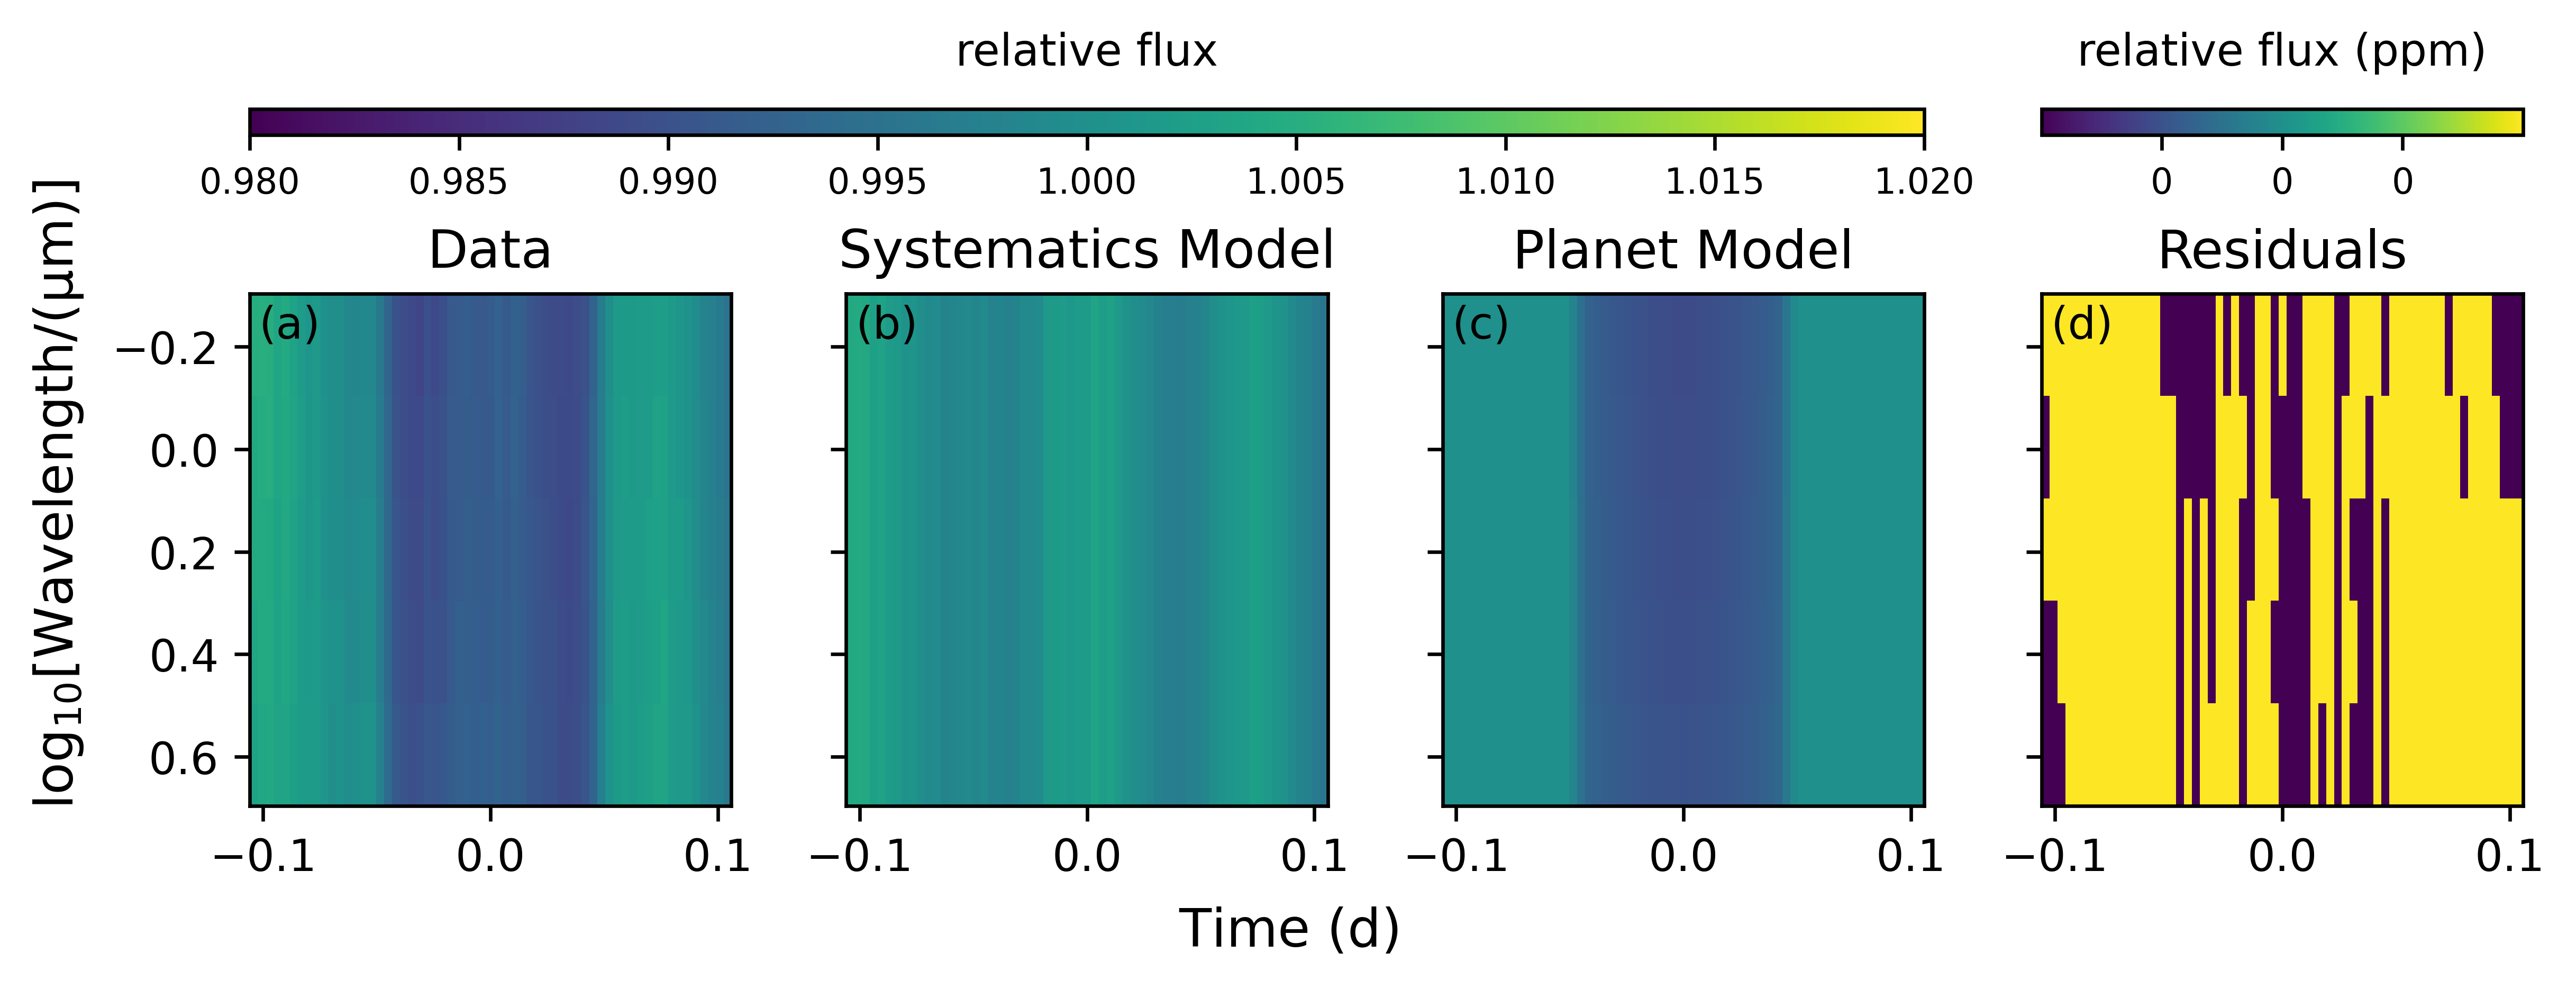

In [15]:
# plot the 3D light curves (flux as a function of time and wavelength) with the residuals (NOT WORKING DUE TO JWST HACKS!)
cm.imshow_with_models()

In [14]:
cm.animate_with_models('test.gif', orientation='horizontal')

TypeError: animate_with_models() takes 1 positional argument but 2 were given